In [34]:
import rasterio as rio
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping

In [ ]:
import sys
args = sys.argv
input_folder = args[1]
glacier_outline = args[2]

inputs: -img_path -glacier_shpfile_path

In [35]:
# input_folder = '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/stitched_by_sat/' # folder with images to coregister

In [36]:
# glacier_outline = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/main_ice_outline.shp'

In [4]:
def rio_write(out_path, nparray, ref_raster, grid_spacing):
    # Function to write a numpy array to a Geotiff using rasterio
    # The geotiff will have the same bounds and crs as the reference raster
    # An evenly-spaced grid will be created with the grid spacing entered
    #
    # INPUTS:
    #   out_path: the path with name of the output gtiff file
    #   nparray: the nparray to write to gtiff
    #   ref_raster: the reference raster reader (we borrow its crs and bounding coordinates)
    #   grid_spacing: the spatial resolution of the output raster
    
    import rasterio as rio
    import numpy as np
    nparray = np.array(nparray) # make sure it's an np array
    
    with rio.open(out_path,'w',
                      driver='GTiff',
                      height=nparray.shape[0], # new shape
                      width=nparray.shape[1], # new shape
                      dtype=nparray.dtype, # data type
                      count=1,
                      crs=ref_raster.crs, # the EPSG from the original DEM
                      transform=rio.Affine(grid_spacing, 0.0, ref_raster.bounds.left, # modified transform
                                           0.0, -grid_spacing, ref_raster.bounds.top)) as dst:
            dst.write(nparray, 1)

In [5]:
def normxcorr2(template, image, mode="full"):
    import numpy as np
    from scipy.signal import fftconvolve
    
    template = template - np.mean(template)
    image = image - np.mean(image)

    a1 = np.ones(template.shape)
    # Faster to flip up down and left right then use fftconvolve instead of scipy's correlate
    ar = np.flipud(np.fliplr(template))
    out = fftconvolve(image, ar.conj(), mode=mode)
    
    image = fftconvolve(np.square(image), a1, mode=mode) - \
            np.square(fftconvolve(image, a1, mode=mode)) / (np.prod(template.shape))

    # Remove small machine precision errors after subtraction
    image[np.where(image < 0)] = 0

    template = np.sum(np.square(template))
    out = out / np.sqrt(image * template)

    # Remove any divisions by 0 or very close to 0
    out[np.where(np.logical_not(np.isfinite(out)))] = 0
    
    return out

## Test coregistration w/ two offset images

In [45]:
# test_imreader = rio.open(input_folder+file); test_im1 = test_imreader.read(1)
# test_im1[np.isnan(test_im1)] = 0
# fig, ax = plt.subplots(figsize=(8,8))
# imcor = ax.imshow(test_im1); fig.colorbar(imcor, ax=ax)
# plt.show()

In [46]:
# test_im2 = test_im1[:-2,:-1]
# print(test_im2.shape)
# test_im2 = np.concatenate([np.zeros((test_im2.shape[0],1)),test_im2], axis=1) # columns
# test_im2 = np.concatenate([np.zeros((2,test_im2.shape[1])),test_im2], axis=0) # rows
# fig, ax = plt.subplots(figsize=(8,8))
# imcor = ax.imshow(test_im2); fig.colorbar(imcor, ax=ax); plt.show()
# print(test_im1.shape)
# print(test_im2.shape)

In [47]:
# plt.imshow(test_im1-test_im2, cmap='seismic',vmin=-100, vmax=100); plt.colorbar(); plt.show()

In [48]:
# corr = normxcorr2(test_im1, test_im2 , mode="full") # normalized 2D cross correlation

In [49]:
# [y,x] = np.where(corr == np.nanmax(corr))
# print(y,x)
# fig, ax = plt.subplots(figsize=(8,8))
# imcor = ax.imshow(corr); fig.colorbar(imcor, ax=ax); plt.title('2D correlation')
# plt.plot(x,y,'r^')
# plt.show()

In [50]:
# shift2_y = test_im2.shape[0]-y[0] # number of pixels to shift im2 left
# shift2_x = test_im2.shape[1]-x[0] # number of pixels to shift im2 up 
# # must add 1
# if shift2_y > 0:
#     shift2_y+=1
# elif shift2_y <= 0:
#     shift2_y+=-1
    
# if shift2_x > 0:
#     shift2_x+=1
# elif shift2_x <= 0:
#     shift2_x+=-1
# print(shift2_y, shift2_x)

In [51]:
# shifted_im2 = test_im2
# [ylen,xlen] = shifted_im2.shape

# # do x first
# if shift2_x > 0: # if the image has been moved to the left
#     shifted_im2 = shifted_im2[:,:xlen-shift2_x] # grab image from left edge
#     shifted_im2 = np.concatenate([np.zeros((ylen,shift2_x)),shifted_im2], axis=1) # add columns from left edge
# elif shift2_x < 0: # if the image has been moved to the right
#     shifted_im2 = shifted_im2[:,abs(shift2_x):] # grab the image from the right edge
#     shifted_im2 = np.concatenate([shifted_im2,np.zeros((ylen,abs(shift2_x)))], axis=1) # add columns from right edge
    
# # then shift y
# if shift2_y > 0: # if the image has been moved up
#     shifted_im2 = shifted_im2[:ylen-shift2_y,:] # grab image from the top edge
#     shifted_im2 = np.concatenate([np.zeros((shift2_y,xlen)),shifted_im2], axis=0) # add rows from the top
# elif shift2_y < 0: # if the image has moved down
#     shifted_im2 = shifted_im2[abs(shift2_y):,:] # grab image from the bottom edge
#     shifted_im2 = np.concatenate([shifted_im2,np.zeros((abs(shift2_y),xlen))], axis=0) # add rows from bottom

# # shifted_im2 = np.concatenate([np.zeros((shift2_y,shifted_im2.shape[1])),shifted_im2], axis=0)
# plt.figure(); plt.imshow(shifted_im2); plt.colorbar(); plt.show()

In [52]:
# # difference should now be 0
# fig, ax = plt.subplots(figsize=(8,8))
# plt.imshow(test_im1-shifted_im2, cmap='seismic',vmin=-100, vmax=100); plt.colorbar(); plt.title('difference')
# plt.show()

# Coregistration function

In [53]:
def coregister(basepath, filelist, glacier_outline, OFFSET_THRESH=200, CORR_THRESH=0.95):
    import geopandas as gpd
    import rasterio as rio
    import numpy as np
    from rasterio.mask import mask
    from shapely.geometry import mapping
    # INPUTS: basepath = rootpath for the files
    # filelist = list of files within rootpath
    # glacier_outline = path to shapefile for determining glacier coverage
    # OFFSET_THRESH: maximum number of pixels in both x and y direction where the max correlation exists
    # CORR_THRESH: 0 to 1. Minimum correlation acceptable between 2 images
    
    # read in glacier shapefile
    glacier_gdf = gpd.read_file(glacier_outline)
    glacier = glacier_gdf.geometry.values
    
    # go through all files in filelist and determine that with greatest glacier coverage
    # if all the same, just pick the first one to be REF_IMAGE
    coverage_compare = []
    for file in filelist:
        reader = rio.open(basepath+file) # open the file
        # crop image to glacier outline
        try:
            out_image, out_transform = mask(reader, [mapping(glacier[0])], crop=True)
            crop_array = out_image[0,:,:]
            coverage = np.count_nonzero(crop_array[~np.isnan(crop_array)]) # calculate pixels of coverage
            coverage_compare.append(coverage)
        except Exception:
            coverage_compare.append(np.NaN)
            continue
    # determine the file with the greatest glacier coverage
    ref_img_idx = np.nanargmax(coverage_compare)
    reffile = filelist[ref_img_idx]
    REF_IMAGE = rio.open(basepath+reffile) # use REF_IMAGE as image 1
    ref_img = REF_IMAGE.read(1)
    print(reffile)
    
    # 2D cross-correlation with other images to determine any systematic x/y offset
    filelist.remove(reffile) # remove reference file from filelist
    print(filelist)
    for file in filelist:
        img_reader = rio.open(basepath+file); img = img_reader.read(1) # read in file
        ref_img[np.isnan(ref_img)] = 0; img[np.isnan(img)] = 0 # set both image Nans to 0s
        
#         # plot the two images
#         fs=16
#         fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
#         im1 = ax1.imshow(ref_img); fig.colorbar(im1, ax=ax1); ax1.set_title(reffile)
#         im2 = ax2.imshow(img); fig.colorbar(im2, ax=ax2); ax2.set_title(file)
        
        # 2D cross correlation 
        # only cross-correlate the overlapping area between the two
        cover1 = ref_img.copy(); cover2 = img.copy()
        cover1[cover1 > 0] = 1 # binary coverage mask
        cover2[cover2 > 0] = 1
        overlap = cover1*cover2
        
#         plt.figure(); plt.imshow(overlap, vmin=0, vmax=1); plt.colorbar(); plt.title('Overlap'); plt.show()
        
        if np.count_nonzero(overlap) > 0:
            corr = normxcorr2(ref_img*overlap, img*overlap, mode="full")
            [y,x] = np.where(corr == np.nanmax(corr)) # find maximum correlation

#             # plot the difference map and corr
#             fs=16
#             fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
#             im1 = ax1.imshow(img-ref_img, cmap='seismic',vmin=-100,vmax=100); 
#             fig.colorbar(im1, ax=ax1); ax1.set_title('diff') # difference map
#             imcor = ax2.imshow(corr,vmin=-1,vmax=1); ax2.set_title('Max corr: '+str(np.nanmax(corr))); # corr 
#             plt.plot(x,y,'r^') # plot max corr
#             fig.colorbar(imcor, ax=ax2); plt.show()

            # if the maximum correlation passes the threshold, find the systematic x,y offset that it corresponds to
            if np.nanmax(corr) >= CORR_THRESH:
                # identify offset
                shift2_y = img.shape[0]-y[0] # number of pixels to shift im2 left
                shift2_x = img.shape[1]-x[0] # number of pixels to shift im2 up 
                # must add 1
                if shift2_y > 0: # shift2_y
                    shift2_y+=1
                elif shift2_y <= 0:
                    shift2_y+=-1
                if shift2_x > 0: # shift2_x
                    shift2_x+=1
                elif shift2_x <= 0:
                    shift2_x+=-1
                print(shift2_y, shift2_x)

                # if the systematic offset is within the search range specified by OFFSET_THRESH
                if shift2_y <= OFFSET_THRESH and shift2_y <= OFFSET_THRESH:

                    # shift second image using x/y offset
                    shifted_im2 = img
                    [ylen,xlen] = shifted_im2.shape
                    print(shifted_im2.shape)
                    # do x first
                    if shift2_x > 0: # if the image has been moved to the left
                        shifted_im2 = shifted_im2[:,:xlen-shift2_x] # grab image from left edge
                        shifted_im2 = np.concatenate([np.zeros((ylen,shift2_x)),shifted_im2], axis=1) # add columns from left edge
                    elif shift2_x < 0: # if the image has been moved to the right
                        shifted_im2 = shifted_im2[:,abs(shift2_x):] # grab the image from the right edge
                        shifted_im2 = np.concatenate([shifted_im2,np.zeros((ylen,abs(shift2_x)))], axis=1) # add columns from right edge
                    print(shifted_im2.shape)
                    # then shift y
                    if shift2_y > 0: # if the image has been moved up
                        shifted_im2 = shifted_im2[:ylen-shift2_y,:] # grab image from the top edge
                        shifted_im2 = np.concatenate([np.zeros((shift2_y,xlen)),shifted_im2], axis=0) # add rows from the top
                    elif shift2_y < 0: # if the image has moved down
                        shifted_im2 = shifted_im2[abs(shift2_y):,:] # grab image from the bottom edge
                        shifted_im2 = np.concatenate([shifted_im2,np.zeros((abs(shift2_y),xlen))], axis=0) # add rows from bottom

#                     # plot before and after coregistration
#                     fs=16
#                     fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
#                     im1 = ax1.imshow(img-ref_img, cmap='seismic',vmin=-100,vmax=100); 
#                     fig.colorbar(im1, ax=ax1); ax1.set_title('diff before coregistration') # difference map
#                     im2 = ax2.imshow(shifted_im2-ref_img, cmap='seismic',vmin=-100,vmax=100);
#                     fig.colorbar(imcor, ax=ax2); ax2.set_title('diff after coregistration'); plt.show()

                    # save new modified raster with original transform and CRS using rio_write()
                    print('Shifted and resaved',file)
                    out_path=basepath+file
                    rio_write(out_path, shifted_im2, REF_IMAGE, REF_IMAGE.transform[0])
                else:
                    print('Offset exceeds realistic values from coregistration error, set as',OFFSET_THRESH)
            else:
                print('Maximum correlation value of',str(np.nanmax(corr)), 'below threshold of', str(CORR_THRESH))
        else:
            print('Images do not overlap. Skip coregistration.')

# grab all image files from within a folder

If different satellite IDs detected, group them by day and coregister all for each day: grab unique_dates, loop by unique_date, coregister

If only different dates detected (after stitching by sat chunk), just coregister them all with each other!!

In [43]:
# determine whether to coregister all files or sat chunks
allfiles = os.listdir(input_folder)
for file in allfiles:
    # if only dates remain:
    if file.startswith('PS') and len(file.split('_')) == 2:
        filetype = 'dates' 
    elif file.startswith('PS') and len(file.split('_')) > 2:
        filetype = 'sats'
    elif file.endswith('harmonized_clip_5m.tif'):
        filetype = 'tiles'
    else:
        filetype = 'image name structure not recognized'
print(filetype)

sats


PS_20200910_106c.tif
['PS_20200910_1049.tif', 'PS_20200910_2263.tif']


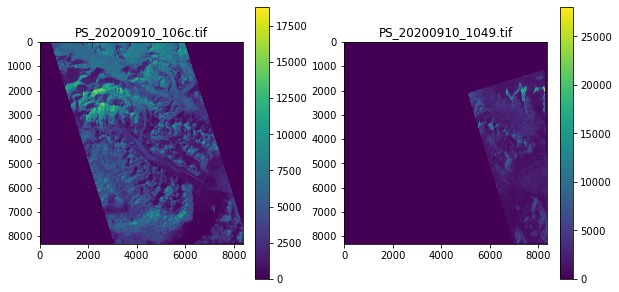

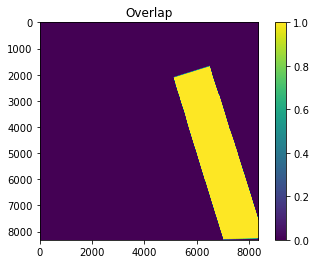

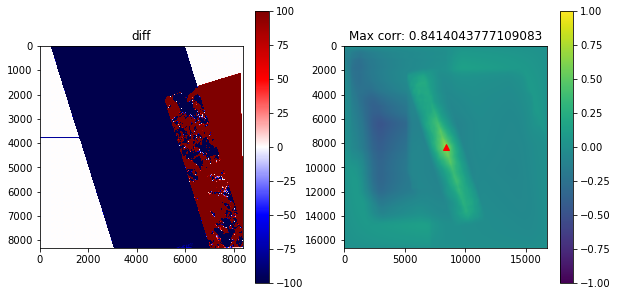

-2 -1
(8317, 8360)
(8317, 8360)


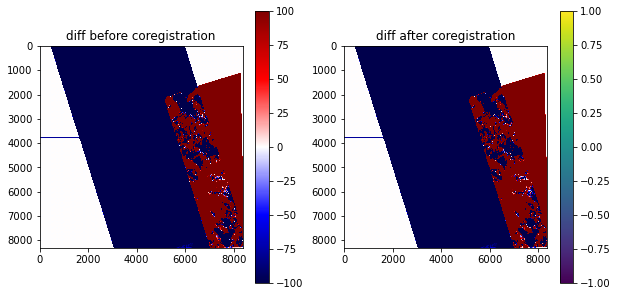

Shifted and resaved PS_20200910_1049.tif


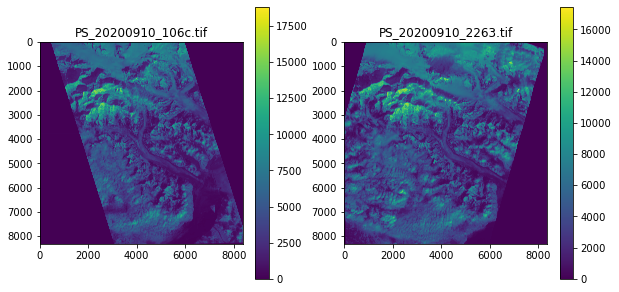

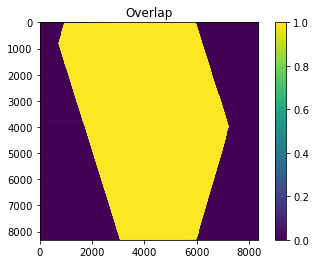

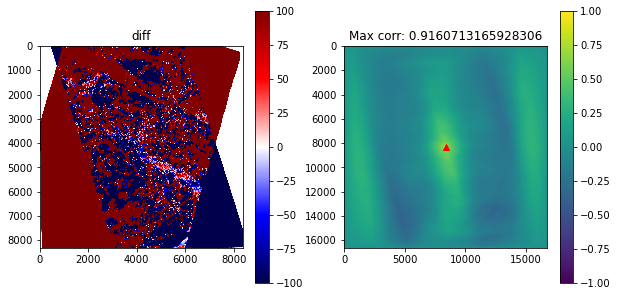

2 -2
(8317, 8360)
(8317, 8360)


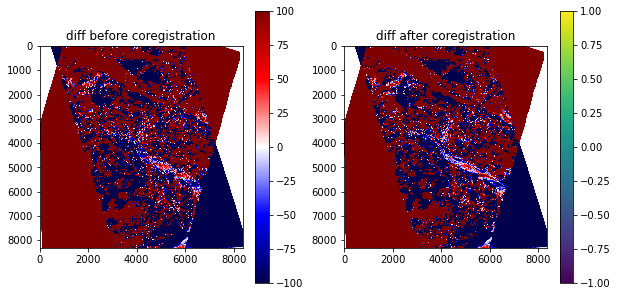

Shifted and resaved PS_20200910_2263.tif
PS_20200911_2212.tif
['PS_20200911_100d.tif']


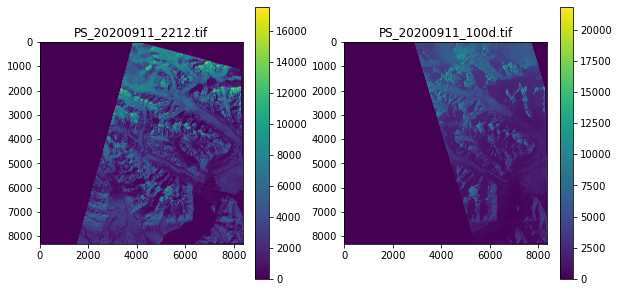

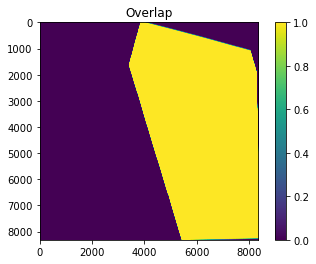

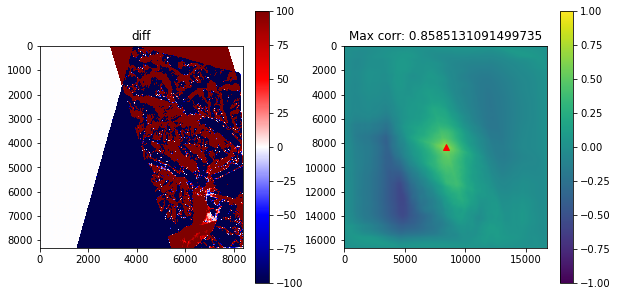

-2 -2
(8317, 8360)
(8317, 8360)


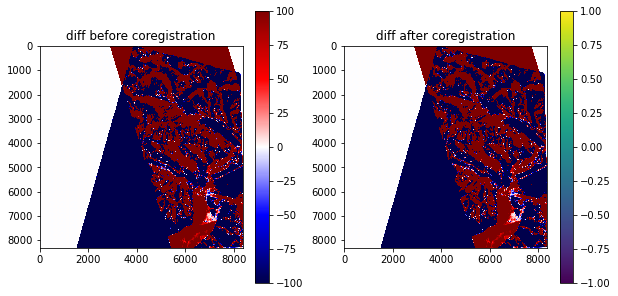

Shifted and resaved PS_20200911_100d.tif
PS_20200912_2206.tif
['PS_20200912_1008.tif', 'PS_20200912_1065.tif']


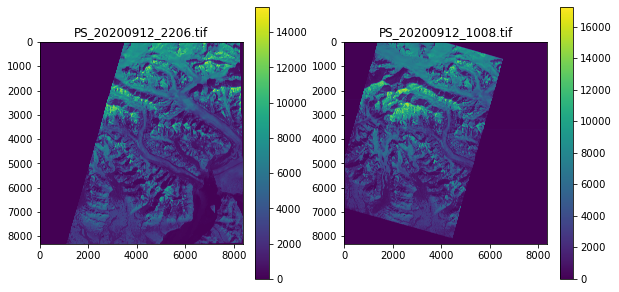

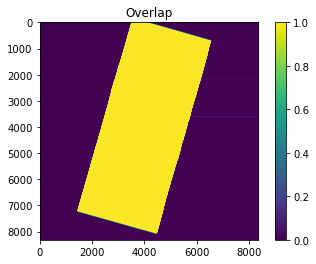

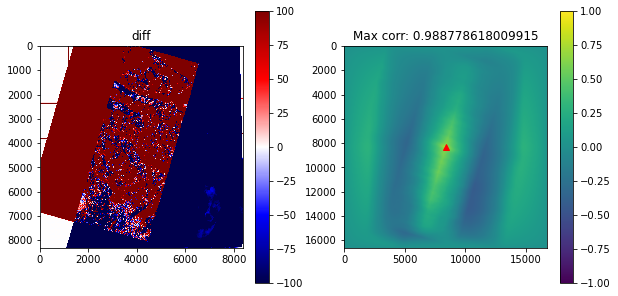

-2 -2
(8317, 8360)
(8317, 8360)


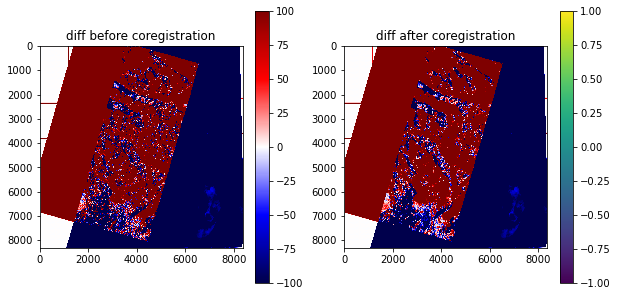

Shifted and resaved PS_20200912_1008.tif


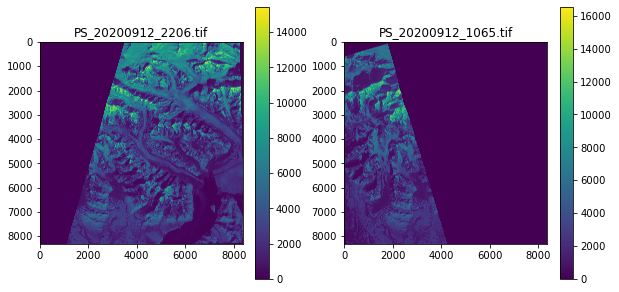

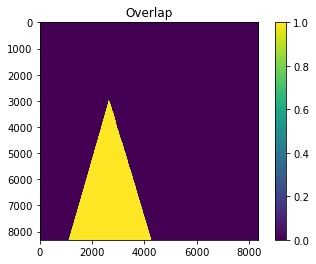

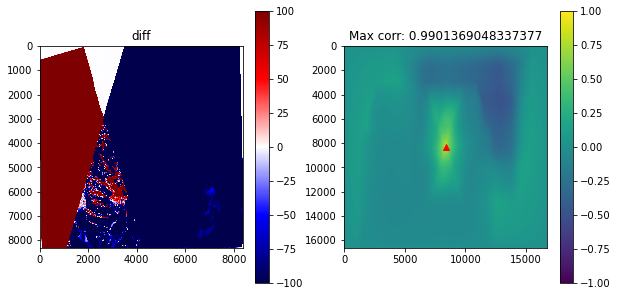

2 2
(8317, 8360)
(8317, 8360)


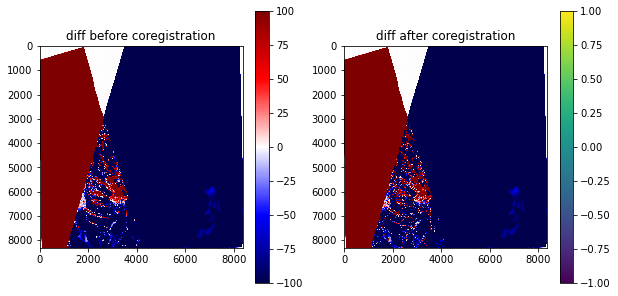

Shifted and resaved PS_20200912_1065.tif
PS_20200913_1058.tif
['PS_20200913_1050.tif']


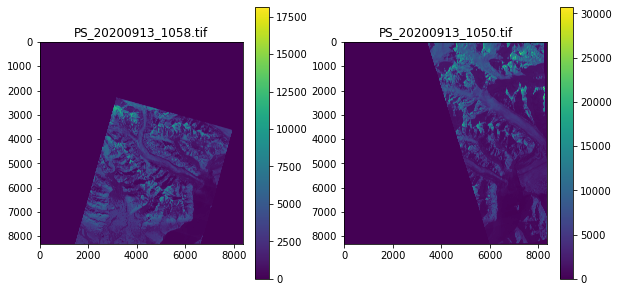

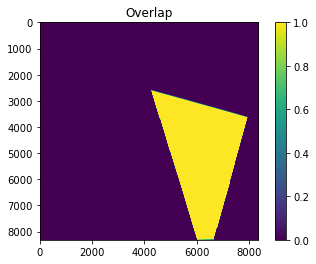

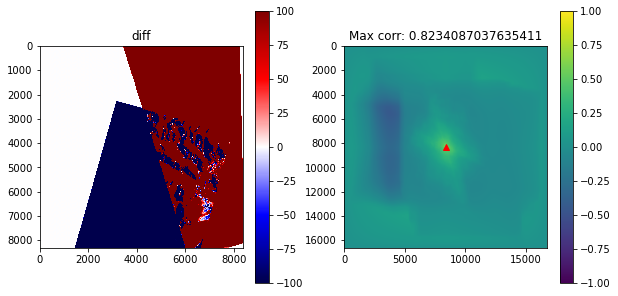

2 2
(8317, 8360)
(8317, 8360)


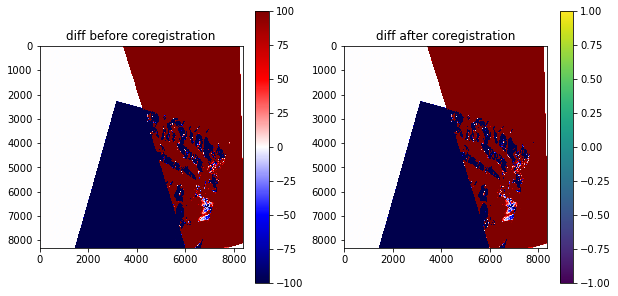

Shifted and resaved PS_20200913_1050.tif
PS_20200914_1025.tif
['PS_20200914_1054.tif']


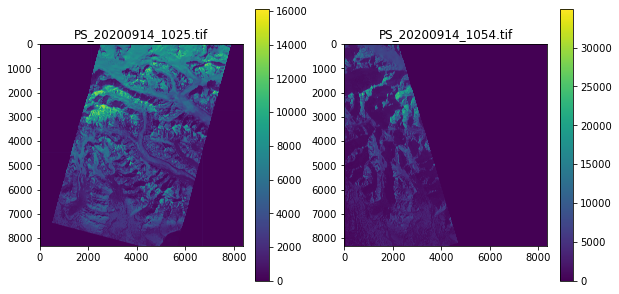

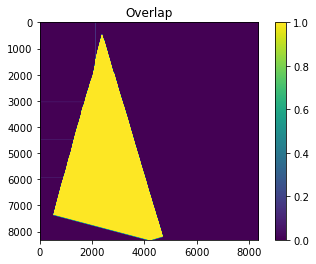

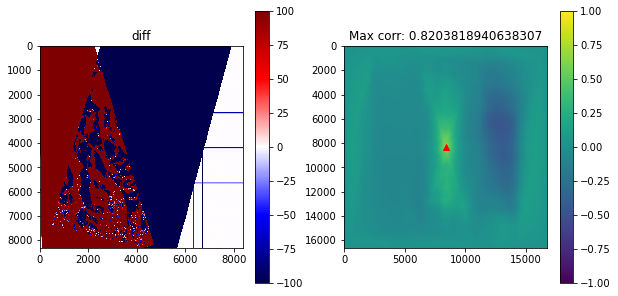

3 -2
(8317, 8360)
(8317, 8360)


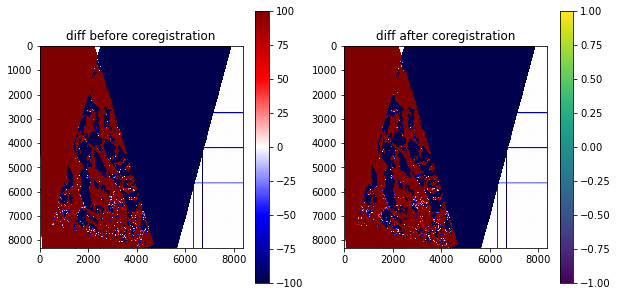

Shifted and resaved PS_20200914_1054.tif
PS_20200916_2231.tif
['PS_20200916_100d.tif', 'PS_20200916_106e.tif']


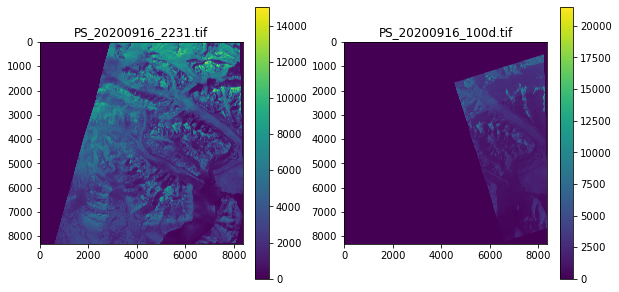

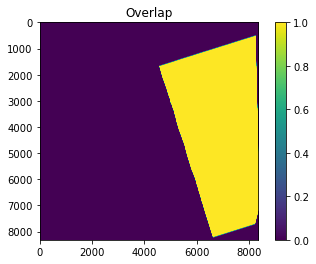

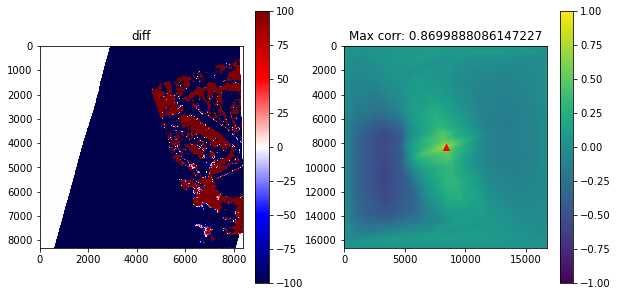

2 3
(8317, 8360)
(8317, 8360)


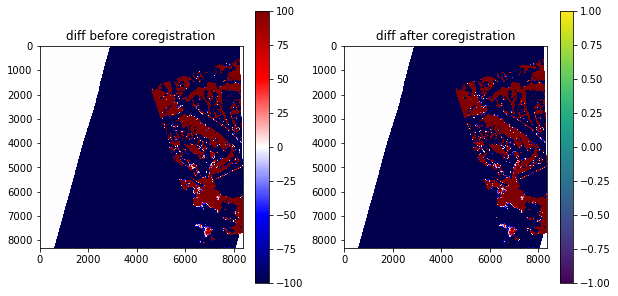

Shifted and resaved PS_20200916_100d.tif


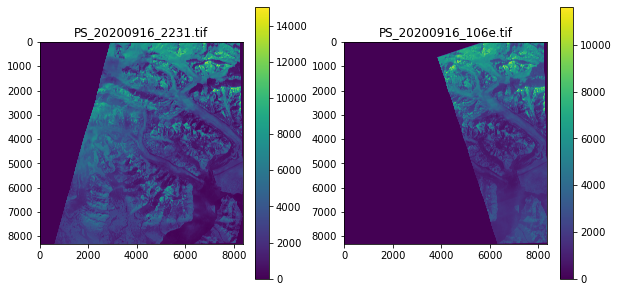

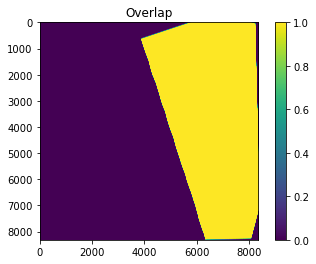

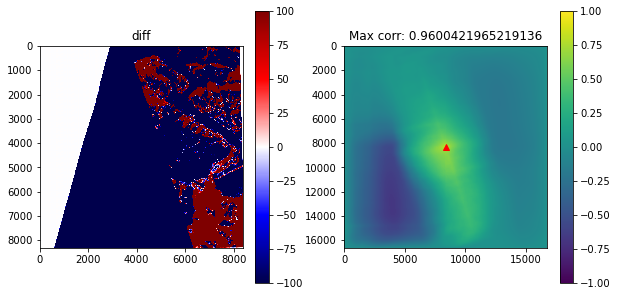

2 3
(8317, 8360)
(8317, 8360)


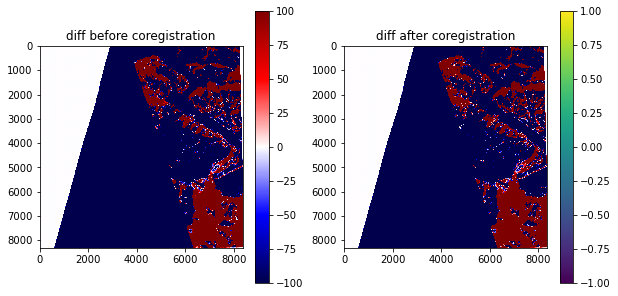

Shifted and resaved PS_20200916_106e.tif
PS_20200918_2412.tif
['PS_20200918_1066.tif', 'PS_20200918_106c.tif']


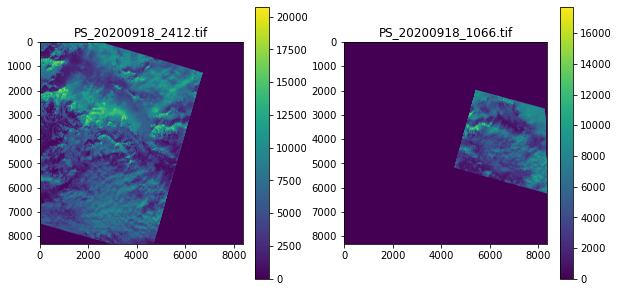

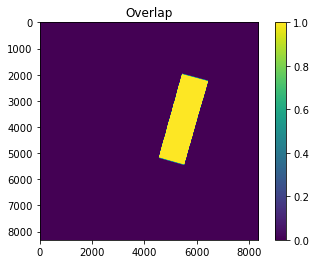

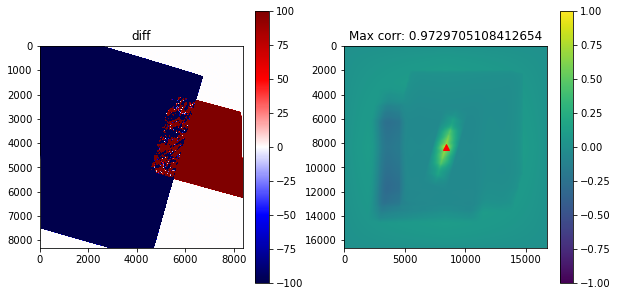

2 2
(8317, 8360)
(8317, 8360)


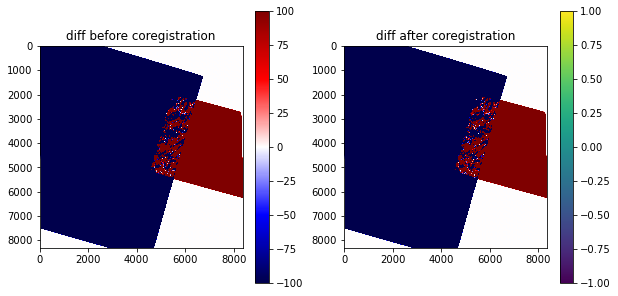

Shifted and resaved PS_20200918_1066.tif


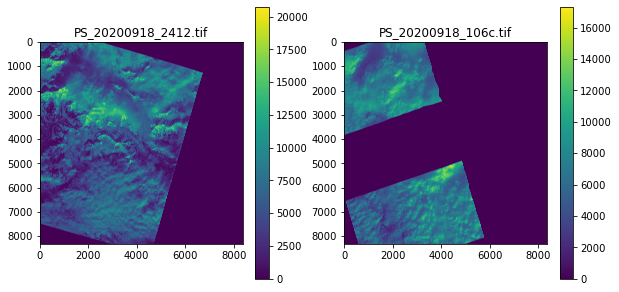

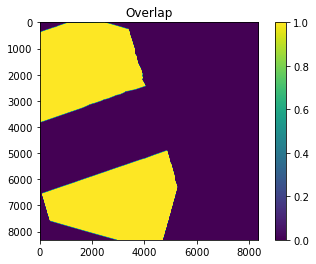

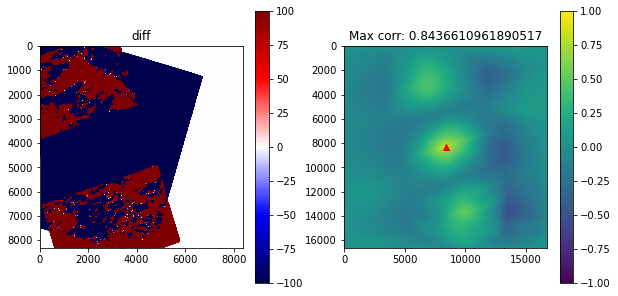

2 2
(8317, 8360)
(8317, 8360)


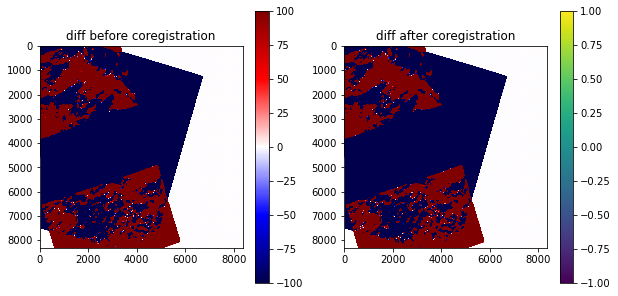

Shifted and resaved PS_20200918_106c.tif


In [44]:
if filetype == 'dates':     
    filelist = allfiles # the file list is all files
    coregister(input_folder,filelist, glacier_outline, OFFSET_THRESH=5, CORR_THRESH=0.8)
    
elif filetype == 'sats':
    # grab all unique dates for satellite chunks
    dates=[]
    for file in allfiles:
        dates.append(file.split('_')[1])
    unique_dates = list(set(dates)); unique_dates.sort()
    
    # for each date
    for date in unique_dates:
        dayfiles = [] # gather files for each day
        for file in allfiles:
            if date in file:
                dayfiles.append(file)
        # if multiple dayfiles, coregister them
        if len(dayfiles) > 1:
            coregister(input_folder, dayfiles, glacier_outline, OFFSET_THRESH=5, CORR_THRESH=0.8)
elif filetype == 'tiles':
    # grab all unique satellite dates
    dates= []; sats = []
    for file in allfiles:
        date = file.split('_')[0]
        satID = file.split('_')[-7]
        dates.append(date); sats.append(satID)
    datesat_df = pd.DataFrame(list(zip(dates, sats)), columns=['date','satID'])
    datesat_df = datesat_df.drop_duplicates()
    for idx, row in datesat_df.iterrows():
        datesatfiles = []
        for file in allfiles:
            if row.date in file and row.satID in file:
                datesatfiles.append(file)
        if len(datesatfiles) > 1:
            coregister(input_folder, datesatfiles, glacier_outline, OFFSET_THRESH=5, CORR_THRESH=0.8)